Epoch 01 | TrainLoss=1.4642 Acc=24.85% | ValLoss=1.3866 Acc=25.53%
Epoch 02 | TrainLoss=1.4021 Acc=29.02% | ValLoss=1.3799 Acc=27.13%
Epoch 03 | TrainLoss=1.3794 Acc=33.48% | ValLoss=1.3671 Acc=26.60%
Epoch 04 | TrainLoss=1.3638 Acc=35.23% | ValLoss=1.3530 Acc=36.70%
Epoch 05 | TrainLoss=1.3340 Acc=36.97% | ValLoss=1.3354 Acc=40.96%
Epoch 06 | TrainLoss=1.3173 Acc=37.20% | ValLoss=1.3148 Acc=43.09%
Epoch 07 | TrainLoss=1.3030 Acc=37.50% | ValLoss=1.2954 Acc=44.68%
Epoch 08 | TrainLoss=1.2894 Acc=40.91% | ValLoss=1.2764 Acc=46.28%
Epoch 09 | TrainLoss=1.2814 Acc=39.47% | ValLoss=1.2600 Acc=45.74%
Epoch 10 | TrainLoss=1.2807 Acc=40.23% | ValLoss=1.2476 Acc=48.94%
Epoch 11 | TrainLoss=1.2572 Acc=42.12% | ValLoss=1.2337 Acc=51.06%
Epoch 12 | TrainLoss=1.2550 Acc=43.64% | ValLoss=1.2231 Acc=50.00%
Epoch 13 | TrainLoss=1.2506 Acc=42.27% | ValLoss=1.2118 Acc=53.72%
Epoch 14 | TrainLoss=1.2414 Acc=43.18% | ValLoss=1.2043 Acc=51.60%
Epoch 15 | TrainLoss=1.2403 Acc=44.85% | ValLoss=1.1950 Acc=53

<Figure size 600x600 with 0 Axes>

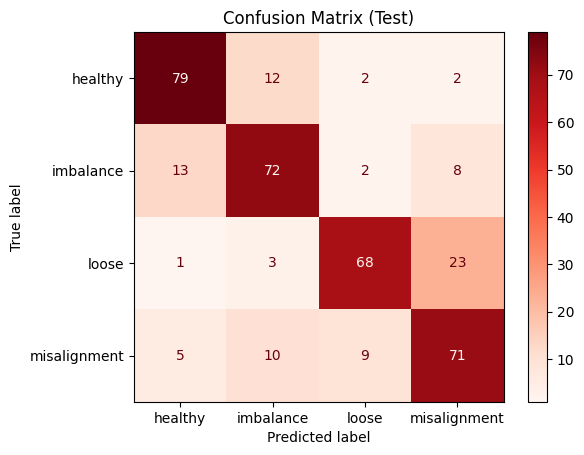

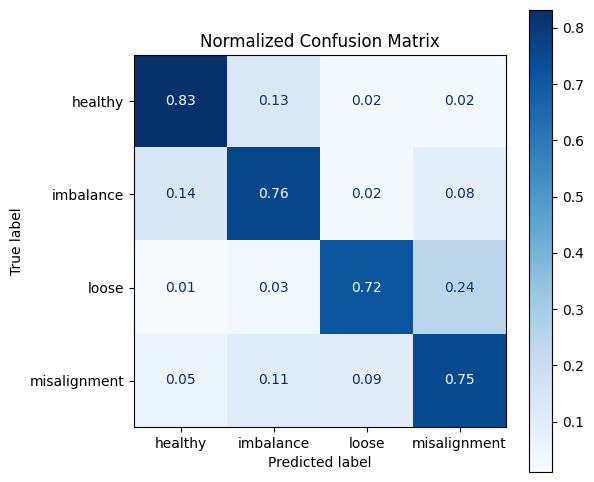

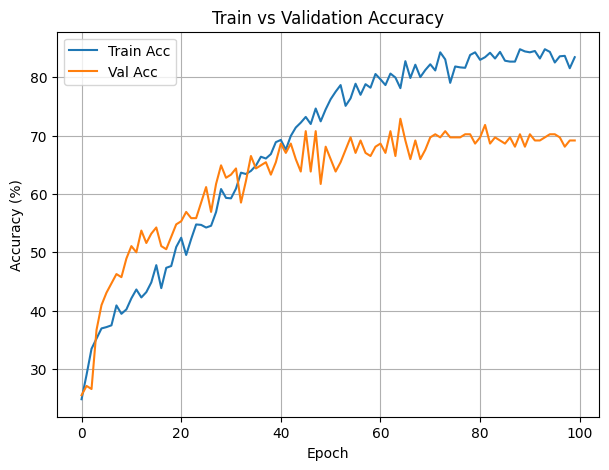

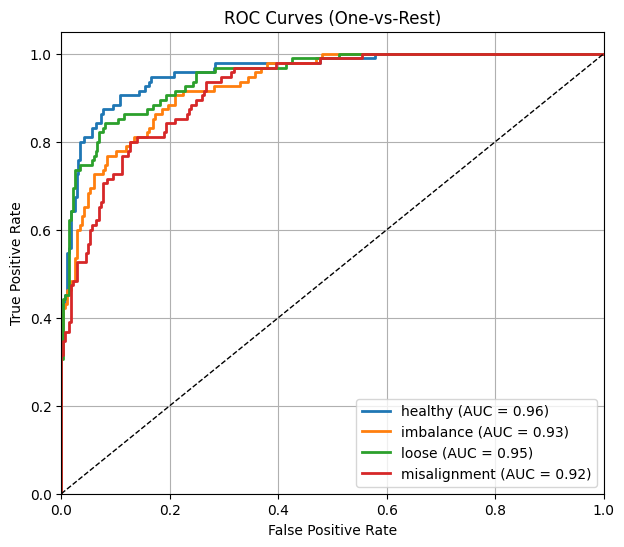

In [5]:
# =========================
# Hybrid (1D+2D) CNNv2 backbone — filename-temelli yükleme + validation split fix
# =========================

import os, random, copy, warnings
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F  # <- FiLM modelinde ReLU/AdaptiveAvgPool için
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from torchvision import models

warnings.filterwarnings("ignore")

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

# -------------------------
# 1) Paths & labels
# -------------------------
csv_path = r"C:\Users\VICTUS\OneDrive\Masaüstü\EECSL\all_segments_1d_features_new.csv"
img_root = r"C:\Users\VICTUS\Pictures\(1.5-4.5s)\Reassigned_New(1.5-4.5s)"
labels = ['healthy', 'imbalance', 'loose', 'misalignment']

BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = len(labels)
FEATURE_DIM = 19

# -------------------------
# 2) Load CSV & normalize 1D features using TRAIN only
# -------------------------
df = pd.read_csv(csv_path)
feature_cols = [c for c in df.columns if c.startswith('feat_')]

expected_splits = {'train','validation','test'}
actual_splits = set(df['split'].unique())
missing = expected_splits - actual_splits
if missing:
    raise ValueError(f"CSV 'split' kolonunda eksik set(ler) var: {missing}. Lütfen 2D index map ile uyumu kontrol et.")

means = df[df['split']=='train'][feature_cols].mean()
stds  = df[df['split']=='train'][feature_cols].std().replace(0, 1e-6)
df[feature_cols] = (df[feature_cols] - means) / stds

# -------------------------
# 3) Augmentation (hafif SpecAugment-like)
# -------------------------
def time_freq_mask(img, T=0.20, F=0.20, num=2):
    h, w, _ = img.shape
    out = img.copy()
    for _ in range(num):
        f = int(F*h*random.random())
        if f > 0:
            f0 = random.randint(0, max(0, h - f))
            out[f0:f0+f, :, :] = 0.0
        t = int(T*w*random.random())
        if t > 0:
            t0 = random.randint(0, max(0, w - t))
            out[:, t0:t0+t, :] = 0.0
    return out

def simple_aug(img):
    if random.random() < 0.30:
        img = time_freq_mask(img, T=0.20, F=0.20, num=2)
    return img

# Kendi ölçtüğün normalize değerler
IMAGENET_MEAN = np.array([0.604423, 0.503053, 0.283058], dtype=np.float32)
IMAGENET_STD  = np.array([0.361984, 0.387896, 0.374654], dtype=np.float32)

# -------------------------
# 4) Dataset
# -------------------------
class FusionDataset(Dataset):
    def __init__(self, df, img_root, split, label_list, augment=False):
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.img_root = img_root
        self.labels = label_list
        self.augment = augment
        if 'filename' not in self.df.columns:
            raise ValueError("CSV içinde 'filename' kolonu yok. 2D index map ile üretilmiş CSV gereklidir.")
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_dir = os.path.join(self.img_root, row['split'], row['label'])
        img_name = row['filename']
        img_path = os.path.join(img_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Görsel bulunamadı: {img_path}")
        img = Image.open(img_path).convert("RGB").resize((224,224))
        img = np.array(img).astype(np.float32) / 255.0
        if self.augment:
            img = simple_aug(img); img = img.copy()
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
        img = np.transpose(img, (2,0,1))  # CHW
        x1 = row[feature_cols].values.astype(np.float32)
        y = self.labels.index(row['label'])
        return torch.from_numpy(img), torch.from_numpy(x1), torch.tensor(y, dtype=torch.long)

# -------------------------
# 5) Dataloaders
# -------------------------
train_dataset = FusionDataset(df, img_root, split='train',       label_list=labels, augment=True)
val_dataset   = FusionDataset(df, img_root, split='validation',  label_list=labels, augment=False)
test_dataset  = FusionDataset(df, img_root, split='test',        label_list=labels, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# -------------------------
# 6) Model (FiLM FusionModel entegrasyonu)
# -------------------------
class FusionFiLMModel(nn.Module):
    """
    - Görüntü kolu: 5x Conv-BN-ReLU (stride=2) -> Dropout2d -> GAP -> 256-d vektör
    - Sayısal kolu: FC(->64)->Dropout->FC(->128)
    - FiLM: gamma,beta (128->256) ile görüntü vektörünü modüle eder:  x <- gamma*x + beta
    - Classifier: 256 -> 64 -> num_classes
    - 'backbone' özelliği parametre gruplama ve unfreeze için eklendi.
    """
    def __init__(self, num_numeric_features, num_classes, freeze_backbone=False):
        super().__init__()
        # --- CNN backbone (conv blokları) ---
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn5   = nn.BatchNorm2d(256)
        self.dropout2d = nn.Dropout2d(0.2)
        # backbone parametre gruplaması için bir Sequential (Dropout parametre içermez)
        self.backbone = nn.Sequential(
            self.conv1, self.bn1, nn.ReLU(inplace=True),
            self.conv2, self.bn2, nn.ReLU(inplace=True),
            self.conv3, self.bn3, nn.ReLU(inplace=True),
            self.conv4, self.bn4, nn.ReLU(inplace=True),
            self.conv5, self.bn5, nn.ReLU(inplace=True),
        )

        # --- Numeric branch ---
        self.fc1    = nn.Linear(num_numeric_features, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.fc2    = nn.Linear(64, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.drop_fc = nn.Dropout(0.2)

        # --- FiLM parametreleri (gamma/beta) ---
        self.gamma_fc = nn.Linear(128, 256)
        self.beta_fc  = nn.Linear(128, 256)

        # --- Classifier ---
        self.fc_clf1 = nn.Linear(256, 64)
        self.bn_clf  = nn.BatchNorm1d(64)
        self.dropout_clf = nn.Dropout(0.5)
        self.fc_out  = nn.Linear(64, num_classes)

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, x_img, x_num):
        # CNN forward (Sequential + ayrıca Dropout2d + GAP)
        x = self.backbone(x_img)                 # (B,256,7,7) — 224 -> 7 boyuta kadar stride=2 ile iner
        x = self.dropout2d(x)                    # spatial dropout
        x = F.adaptive_avg_pool2d(x, 1)          # (B,256,1,1)
        x = x.view(x.size(0), -1)                # (B,256)

        # Numeric branch
        z = F.relu(self.bn_fc1(self.fc1(x_num)))
        z = self.drop_fc(z)
        z = F.relu(self.bn_fc2(self.fc2(z)))

        # FiLM: feature-wise linear modulation
        gamma = self.gamma_fc(z)                 # (B,256)
        beta  = self.beta_fc(z)                  # (B,256)
        x = gamma * x + beta                     # modülasyon

        # Classifier
        x = F.relu(self.bn_clf(self.fc_clf1(x)))
        x = self.dropout_clf(x)
        logits = self.fc_out(x)
        return logits

# Cihaz & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# FiLM modelinde freeze_backbone isteğe bağlı; sıfırdan eğitildiği için False makul.
model = FusionFiLMModel(num_numeric_features=FEATURE_DIM, num_classes=NUM_CLASSES, freeze_backbone=False).to(device)

# -------------------------
# 7) Optimizer, scheduler, criterion, device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionFiLMModel(num_numeric_features=FEATURE_DIM, num_classes=NUM_CLASSES, freeze_backbone=False).to(device)

def set_bn_momentum(model, momentum=0.01):
    for m in model.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            m.momentum = momentum
set_bn_momentum(model, 0.01)

# --- FIX: parametre gruplarını kimlik (id) bazlı ayır ---
backbone_params = list(model.backbone.parameters())
backbone_param_ids = {id(p) for p in backbone_params}
# head: modeldeki tüm parametrelerden backbone'a ait olanları çıkar
head_params = [p for p in model.parameters() if id(p) not in backbone_param_ids]

# (Opsiyonel güvenlik)
# assert len(set(backbone_param_ids).intersection({id(p) for p in head_params})) == 0, "Parametre çakışması var!"

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 5e-5, "weight_decay": 1e-6},  # backbone için daha küçük LR örneği
        {"params": head_params,     "lr": 1e-4, "weight_decay": 1e-5},
    ]
)

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
MAX_NORM = 1.0

# Warm-up (kalan kısım aynen)
WARMUP_EPOCHS = 3
base_lrs = [pg["lr"] for pg in optimizer.param_groups]
def warmup(epoch: int):
    if epoch <= WARMUP_EPOCHS:
        scale = epoch / float(WARMUP_EPOCHS)
        for pg, base in zip(optimizer.param_groups, base_lrs):
            pg["lr"] = base * scale

# -------------------------
# 8) Early Stopping
# -------------------------
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.0):
        self.patience = patience; self.min_delta = min_delta
        self.best = np.inf; self.count = 0; self.best_state = None
    def step(self, val_loss, model):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss; self.count = 0
            self.best_state = copy.deepcopy(model.state_dict()); return False
        else:
            self.count += 1; return self.count >= self.patience

early = EarlyStopping(patience=20, min_delta=0.0)

# -------------------------
# 9) Train/Validation loop (freeze->unfreeze)
# -------------------------
train_acc_hist, val_acc_hist = [], []

def set_freeze(module, freeze=True):
    for p in module.parameters():
        p.requires_grad = not freeze

UNFREEZE_EPOCH = 1  # burada zaten freeze=False, ama yapı korunuyor

for epoch in range(1, EPOCHS+1):
    if epoch == UNFREEZE_EPOCH:
        set_freeze(model.backbone, freeze=False)

    # Warmup
    warmup(epoch)

    # ---- Train ----
    model.train()
    tr_loss, tr_correct, tr_total = 0.0, 0, 0
    for X_img, X_feat, y in train_loader:
        X_img, X_feat, y = X_img.to(device), X_feat.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X_img, X_feat)
        loss = criterion(outputs, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
        optimizer.step()

        _, preds = outputs.max(1)
        tr_loss += loss.item() * y.size(0)
        tr_total += y.size(0)
        tr_correct += (preds == y).sum().item()

    train_acc = 100.0 * tr_correct / max(1, tr_total)
    avg_tr_loss = tr_loss / max(1, tr_total)

    # ---- Validation ----
    model.eval()
    va_loss, va_correct, va_total = 0.0, 0, 0
    with torch.no_grad():
        for X_img, X_feat, y in val_loader:
            X_img, X_feat, y = X_img.to(device), X_feat.to(device), y.to(device)
            outputs = model(X_img, X_feat)
            loss = criterion(outputs, y)
            _, preds = outputs.max(1)
            va_loss += loss.item() * y.size(0)
            va_total += y.size(0)
            va_correct += (preds == y).sum().item()

    val_acc = 100.0 * va_correct / max(1, va_total)
    avg_va_loss = va_loss / max(1, va_total)

    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch:02d} | TrainLoss={avg_tr_loss:.4f} Acc={train_acc:.2f}% | ValLoss={avg_va_loss:.4f} Acc={val_acc:.2f}%")

    scheduler.step()

    if early.step(avg_va_loss, model):
        print(f"[EarlyStop] No improvement for {early.patience} checks. Stop at epoch {epoch}.")
        break

# En iyi ağırlıklar
if early.best_state is not None:
    model.load_state_dict(early.best_state)

# Dosya adı — FiLM modeli için güncel
torch.save(model.state_dict(), "best_hybrid_film.pth")
print("Best model saved to best_hybrid_film.pth")

# -------------------------
# 10) Final TEST evaluation + ROC + Confusion Matrices
# -------------------------
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for X_img, X_feat, y in test_loader:
        X_img, X_feat, y = X_img.to(device), X_feat.to(device), y.to(device)
        outputs = model(X_img, X_feat)
        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)
        test_total += y.size(0)
        test_correct += (preds == y).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_probs = np.vstack(all_probs)   # (N, num_classes)
test_acc = 100.0 * test_correct / max(1, test_total)
print(f"\n[TEST] Accuracy = {test_acc:.2f}%")
print("\n--- Classification Report (Test Set) ---")
print(classification_report(all_labels, all_preds, target_names=labels))

# Confusion Matrix (count)
plt.figure(figsize=(6,6))
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Reds', values_format='d')
plt.title('Confusion Matrix (Test)')
plt.show()

# Confusion Matrix (normalized)
plt.figure(figsize=(6,6))
cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp.plot(cmap="Blues", values_format=".2f", ax=plt.gca(), colorbar=True)
plt.title("Normalized Confusion Matrix")
plt.show()

# Learning curves
plt.figure(figsize=(7,5))
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend(); plt.grid(True); plt.show()

# ROC–AUC (one-vs-rest)
y_true = np.array(all_labels)
y_score = np.array(all_probs)   # (N, NUM_CLASSES)
y_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

plt.figure(figsize=(7,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right"); plt.grid(True); plt.show()


Epoch 01 | TrainLoss=1.5003 Acc=27.42% | ValLoss=1.3865 Acc=25.00%
Epoch 02 | TrainLoss=1.4869 Acc=27.73% | ValLoss=1.3835 Acc=26.06%
Epoch 03 | TrainLoss=1.4252 Acc=29.70% | ValLoss=1.3775 Acc=26.60%
Epoch 04 | TrainLoss=1.3976 Acc=32.05% | ValLoss=1.3676 Acc=28.72%
Epoch 05 | TrainLoss=1.3644 Acc=33.86% | ValLoss=1.3540 Acc=36.17%
Epoch 06 | TrainLoss=1.3475 Acc=37.12% | ValLoss=1.3374 Acc=39.36%
Epoch 07 | TrainLoss=1.3475 Acc=34.47% | ValLoss=1.3184 Acc=39.36%
Epoch 08 | TrainLoss=1.3359 Acc=38.26% | ValLoss=1.3021 Acc=43.09%
Epoch 09 | TrainLoss=1.3359 Acc=37.58% | ValLoss=1.2897 Acc=44.15%
Epoch 10 | TrainLoss=1.3258 Acc=37.05% | ValLoss=1.2754 Acc=47.34%
Epoch 11 | TrainLoss=1.3131 Acc=38.41% | ValLoss=1.2653 Acc=45.21%
Epoch 12 | TrainLoss=1.3063 Acc=39.17% | ValLoss=1.2582 Acc=44.15%
Epoch 13 | TrainLoss=1.2956 Acc=38.64% | ValLoss=1.2534 Acc=43.09%
Epoch 14 | TrainLoss=1.2980 Acc=38.26% | ValLoss=1.2454 Acc=43.09%
Epoch 15 | TrainLoss=1.2748 Acc=41.52% | ValLoss=1.2374 Acc=45

<Figure size 600x600 with 0 Axes>

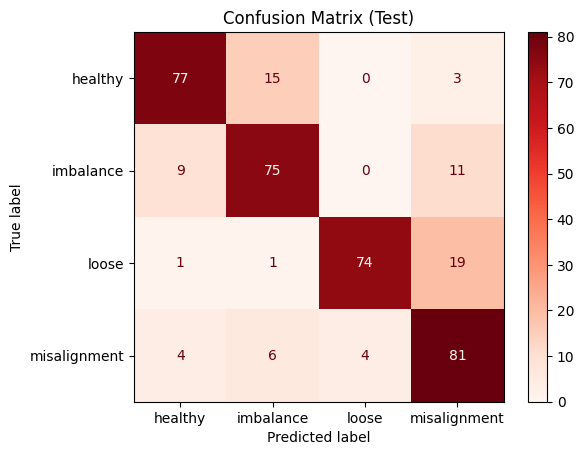

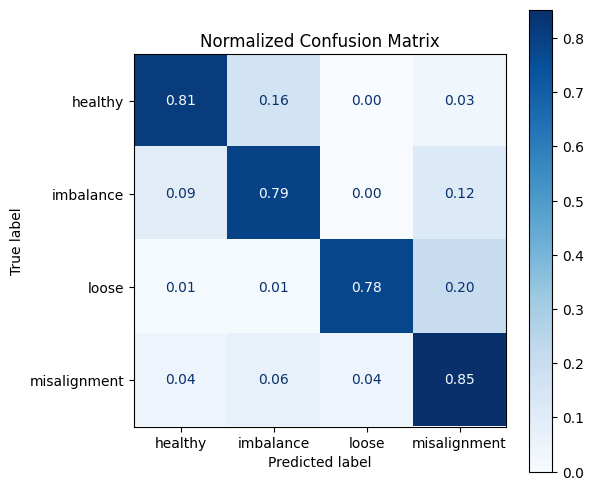

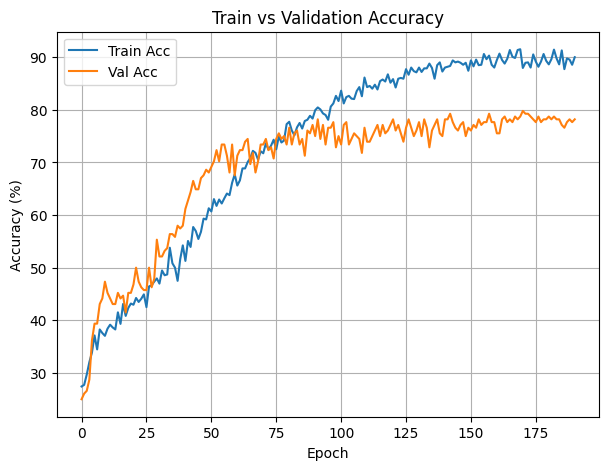

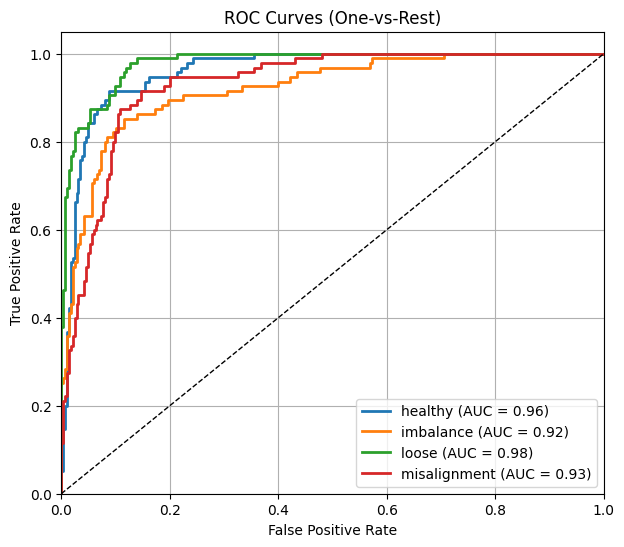

In [3]:
# =========================
# Hybrid (1D+2D) CNNv2 backbone — filename-temelli yükleme + validation split fix
# =========================

import os, random, copy, warnings
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F  # FiLM ve aktivasyonlar için
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from torchvision import models

warnings.filterwarnings("ignore")

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

# -------------------------
# 1) Paths & labels
# -------------------------
csv_path = r"C:\Users\VICTUS\OneDrive\Masaüstü\EECSL\all_segments_1d_features_new.csv"
img_root = r"C:\Users\VICTUS\Pictures\(1.5-4.5s)\Reassigned_New(1.5-4.5s)"
labels = ['healthy', 'imbalance', 'loose', 'misalignment']

BATCH_SIZE = 32
EPOCHS = 200
NUM_CLASSES = len(labels)
FEATURE_DIM = 19

# -------------------------
# 2) Load CSV & normalize 1D features using TRAIN only
# -------------------------
df = pd.read_csv(csv_path)
feature_cols = [c for c in df.columns if c.startswith('feat_')]

expected_splits = {'train','validation','test'}
actual_splits = set(df['split'].unique())
missing = expected_splits - actual_splits
if missing:
    raise ValueError(f"CSV 'split' kolonunda eksik set(ler) var: {missing}. Lütfen 2D index map ile uyumu kontrol et.")

means = df[df['split']=='train'][feature_cols].mean()
stds  = df[df['split']=='train'][feature_cols].std().replace(0, 1e-6)
df[feature_cols] = (df[feature_cols] - means) / stds

# -------------------------
# 3) Augmentation (hafif SpecAugment-like)
# -------------------------
def time_freq_mask(img, T=0.20, F=0.20, num=2):
    h, w, _ = img.shape
    out = img.copy()
    for _ in range(num):
        f = int(F*h*random.random())
        if f > 0:
            f0 = random.randint(0, max(0, h - f))
            out[f0:f0+f, :, :] = 0.0
        t = int(T*w*random.random())
        if t > 0:
            t0 = random.randint(0, max(0, w - t))
            out[:, t0:t0+t, :] = 0.0
    return out

def simple_aug(img):
    if random.random() < 0.30:
        img = time_freq_mask(img, T=0.20, F=0.20, num=2)
    return img

# Kendi ölçtüğün normalize değerler
IMAGENET_MEAN = np.array([0.604423, 0.503053, 0.283058], dtype=np.float32)
IMAGENET_STD  = np.array([0.361984, 0.387896, 0.374654], dtype=np.float32)

# -------------------------
# 4) Dataset
# -------------------------
class FusionDataset(Dataset):
    def __init__(self, df, img_root, split, label_list, augment=False):
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.img_root = img_root
        self.labels = label_list
        self.augment = augment
        if 'filename' not in self.df.columns:
            raise ValueError("CSV içinde 'filename' kolonu yok. 2D index map ile üretilmiş CSV gereklidir.")
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_dir = os.path.join(self.img_root, row['split'], row['label'])
        img_name = row['filename']
        img_path = os.path.join(img_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Görsel bulunamadı: {img_path}")
        img = Image.open(img_path).convert("RGB").resize((224,224))
        img = np.array(img).astype(np.float32) / 255.0
        if self.augment:
            img = simple_aug(img); img = img.copy()
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
        img = np.transpose(img, (2,0,1))  # CHW
        x1 = row[feature_cols].values.astype(np.float32)
        y = self.labels.index(row['label'])
        return torch.from_numpy(img), torch.from_numpy(x1), torch.tensor(y, dtype=torch.long)

# -------------------------
# 5) Dataloaders
# -------------------------
train_dataset = FusionDataset(df, img_root, split='train',       label_list=labels, augment=True)
val_dataset   = FusionDataset(df, img_root, split='validation',  label_list=labels, augment=False)
test_dataset  = FusionDataset(df, img_root, split='test',        label_list=labels, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# -------------------------
# 6) Model (FiLM sadece son iki blokta + sayısal kola L2 için altyapı)
# -------------------------
class FusionFiLMModel(nn.Module):
    """
    - Konvolüsyonlar: 5x Conv-BN (stride=2). FiLM yalnızca conv4 ve conv5 çıkışlarında (BN sonrası, ReLU'dan önce).
    - Sayısal kol: FC(->64)->Dropout->FC(->128). Bu temsil z'den FiLM parametreleri üretilir.
    - GAP sonrası 256-d -> classifier(64) -> num_classes.
    - backbone: conv+bn katmanlarını içerir (parametre gruplama için).
    """
    def __init__(self, num_numeric_features, num_classes, freeze_backbone=False):
        super().__init__()
        # --- CNN katmanları ---
        self.conv1 = nn.Conv2d(3, 16,  kernel_size=3, stride=2, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32,  kernel_size=3, stride=2, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64,  kernel_size=3, stride=2, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, stride=2, padding=1)
        self.bn5   = nn.BatchNorm2d(256)
        self.dropout2d = nn.Dropout2d(0.2)

        # backbone: yalnız conv/bn'leri bir arada tut (ModuleList; forward elle yazılacak)
        self.backbone = nn.ModuleList([self.conv1,self.bn1,self.conv2,self.bn2,
                                       self.conv3,self.bn3,self.conv4,self.bn4,
                                       self.conv5,self.bn5])

        # --- Sayısal kol ---
        self.fc1    = nn.Linear(num_numeric_features, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.fc2    = nn.Linear(64, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.drop_fc = nn.Dropout(0.2)

        # --- FiLM parametreleri: SADECE son iki blok için ---
        self.gamma4_fc = nn.Linear(128, 128)   # conv4 çıkış kanalları için
        self.beta4_fc  = nn.Linear(128, 128)
        self.gamma5_fc = nn.Linear(128, 256)   # conv5 çıkış kanalları için
        self.beta5_fc  = nn.Linear(128, 256)

        # --- Classifier ---
        self.fc_clf1 = nn.Linear(256, 64)
        self.bn_clf  = nn.BatchNorm1d(64)
        self.dropout_clf = nn.Dropout(0.5)
        self.fc_out  = nn.Linear(64, num_classes)

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, x_img, x_num):
        # İlk üç blok (FiLM yok)
        x = F.relu(self.bn1(self.conv1(x_img)))   # -> (B,16,112,112)
        x = F.relu(self.bn2(self.conv2(x)))       # -> (B,32,56,56)
        x = F.relu(self.bn3(self.conv3(x)))       # -> (B,64,28,28)

        # Sayısal kolu hesapla (FiLM parametreleri için temsil z)
        z = F.relu(self.bn_fc1(self.fc1(x_num)))
        z = self.drop_fc(z)
        z = F.relu(self.bn_fc2(self.fc2(z)))      # -> (B,128)

        # --- 4. blok + FiLM(128ch) ---
        x4 = self.bn4(self.conv4(x))              # -> (B,128,14,14)
        gamma4 = self.gamma4_fc(z).unsqueeze(-1).unsqueeze(-1)  # (B,128,1,1)
        beta4  = self.beta4_fc(z).unsqueeze(-1).unsqueeze(-1)   # (B,128,1,1)
        x = F.relu(x4 * gamma4 + beta4)

        # --- 5. blok + FiLM(256ch) ---
        x5 = self.bn5(self.conv5(x))              # -> (B,256,7,7)
        gamma5 = self.gamma5_fc(z).unsqueeze(-1).unsqueeze(-1)  # (B,256,1,1)
        beta5  = self.beta5_fc(z).unsqueeze(-1).unsqueeze(-1)   # (B,256,1,1)
        x = F.relu(x5 * gamma5 + beta5)

        # Dropout2d + GAP
        x = self.dropout2d(x)
        x = F.adaptive_avg_pool2d(x, 1)           # -> (B,256,1,1)
        x = x.view(x.size(0), -1)                 # -> (B,256)

        # Classifier
        x = F.relu(self.bn_clf(self.fc_clf1(x)))
        x = self.dropout_clf(x)
        logits = self.fc_out(x)
        return logits

# Cihaz & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionFiLMModel(num_numeric_features=FEATURE_DIM, num_classes=NUM_CLASSES, freeze_backbone=False).to(device)

# -------------------------
# 7) Optimizer, scheduler, criterion, device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionFiLMModel(num_numeric_features=FEATURE_DIM, num_classes=NUM_CLASSES, freeze_backbone=False).to(device)

def set_bn_momentum(model, momentum=0.01):
    for m in model.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            m.momentum = momentum
set_bn_momentum(model, 0.01)

# Parametre grupları (id-bazlı güvenli ayrım)
backbone_params = list(model.backbone.parameters())
backbone_param_ids = {id(p) for p in backbone_params}
head_params = [p for p in model.parameters() if id(p) not in backbone_param_ids]

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 5e-5, "weight_decay": 1e-6},
        {"params": head_params,     "lr": 1e-4, "weight_decay": 1e-5},
    ]
)

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
MAX_NORM = 1.0

# --- Hafif L2 cezası sadece sayısal kola ---
NUMERIC_L2 = 1e-4  # istersen 5e-5 deneyebilirsin

# Warm-up
WARMUP_EPOCHS = 3
base_lrs = [pg["lr"] for pg in optimizer.param_groups]
def warmup(epoch: int):
    if epoch <= WARMUP_EPOCHS:
        scale = epoch / float(WARMUP_EPOCHS)
        for pg, base in zip(optimizer.param_groups, base_lrs):
            pg["lr"] = base * scale

# -------------------------
# 8) Early Stopping
# -------------------------
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.0):
        self.patience = patience; self.min_delta = min_delta
        self.best = np.inf; self.count = 0; self.best_state = None
    def step(self, val_loss, model):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss; self.count = 0
            self.best_state = copy.deepcopy(model.state_dict()); return False
        else:
            self.count += 1; return self.count >= self.patience

early = EarlyStopping(patience=20, min_delta=0.0)

# -------------------------
# 9) Train/Validation loop (freeze->unfreeze)
# -------------------------
train_acc_hist, val_acc_hist = [], []

def set_freeze(module, freeze=True):
    for p in module.parameters():
        p.requires_grad = not freeze

UNFREEZE_EPOCH = 1  # burada zaten freeze=False, ama yapı korunuyor

for epoch in range(1, EPOCHS+1):
    if epoch == UNFREEZE_EPOCH:
        set_freeze(model.backbone, freeze=False)

    # Warmup
    warmup(epoch)

    # ---- Train ----
    model.train()
    tr_loss, tr_correct, tr_total = 0.0, 0, 0
    for X_img, X_feat, y in train_loader:
        X_img, X_feat, y = X_img.to(device), X_feat.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X_img, X_feat)
        loss = criterion(outputs, y)

        # ----- >>> SAYISAL KOL L2 CEZASI (sadece train) <<<
        # Sadece fc1.weight ve fc2.weight üzerine uyguluyoruz (BN/bias hariç).
        numeric_l2 = (model.fc1.weight.pow(2).sum() + model.fc2.weight.pow(2).sum())
        loss = loss + NUMERIC_L2 * numeric_l2
        # ---------------------------------------------------

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
        optimizer.step()

        _, preds = outputs.max(1)
        tr_loss += loss.item() * y.size(0)
        tr_total += y.size(0)
        tr_correct += (preds == y).sum().item()

    train_acc = 100.0 * tr_correct / max(1, tr_total)
    avg_tr_loss = tr_loss / max(1, tr_total)

    # ---- Validation ----
    model.eval()
    va_loss, va_correct, va_total = 0.0, 0, 0
    with torch.no_grad():
        for X_img, X_feat, y in val_loader:
            X_img, X_feat, y = X_img.to(device), X_feat.to(device), y.to(device)
            outputs = model(X_img, X_feat)
            loss = criterion(outputs, y)  # Val loss'a ekstra L2 eklemiyoruz (saf CE)
            _, preds = outputs.max(1)
            va_loss += loss.item() * y.size(0)
            va_total += y.size(0)
            va_correct += (preds == y).sum().item()

    val_acc = 100.0 * va_correct / max(1, va_total)
    avg_va_loss = va_loss / max(1, va_total)

    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch:02d} | TrainLoss={avg_tr_loss:.4f} Acc={train_acc:.2f}% | ValLoss={avg_va_loss:.4f} Acc={val_acc:.2f}%")

    scheduler.step()

    if early.step(avg_va_loss, model):
        print(f"[EarlyStop] No improvement for {early.patience} checks. Stop at epoch {epoch}.")
        break

# En iyi ağırlıklar
if early.best_state is not None:
    model.load_state_dict(early.best_state)

# Dosya adı — FiLM modeli için güncel
torch.save(model.state_dict(), "best_hybrid_film.pth")
print("Best model saved to best_hybrid_film.pth")

# -------------------------
# 10) Final TEST evaluation + ROC + Confusion Matrices
# -------------------------
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for X_img, X_feat, y in test_loader:
        X_img, X_feat, y = X_img.to(device), X_feat.to(device), y.to(device)
        outputs = model(X_img, X_feat)
        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)
        test_total += y.size(0)
        test_correct += (preds == y).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_probs = np.vstack(all_probs)   # (N, num_classes)
test_acc = 100.0 * test_correct / max(1, test_total)
print(f"\n[TEST] Accuracy = {test_acc:.2f}%")
print("\n--- Classification Report (Test Set) ---")
print(classification_report(all_labels, all_preds, target_names=labels))

# Confusion Matrix (count)
plt.figure(figsize=(6,6))
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Reds', values_format='d')
plt.title('Confusion Matrix (Test)')
plt.show()

# Confusion Matrix (normalized)
plt.figure(figsize=(6,6))
cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp.plot(cmap="Blues", values_format=".2f", ax=plt.gca(), colorbar=True)
plt.title("Normalized Confusion Matrix")
plt.show()

# Learning curves
plt.figure(figsize=(7,5))
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend(); plt.grid(True); plt.show()

# ROC–AUC (one-vs-rest)
y_true = np.array(all_labels)
y_score = np.array(all_probs)   # (N, NUM_CLASSES)
y_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

plt.figure(figsize=(7,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right"); plt.grid(True); plt.show()
